# 휴먼인더루프

In [ ]:
 %pip install -Uq langgraph langsmith langchain_groq langchain_tavily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "08-LangGraph-State-Customization"

In [ ]:
from pydantic import BaseModel
from typing import TypedDict, Annotated

from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch

from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.memory import MemorySaver


search = TavilySearch(max_results=3)


class HumanRequest(BaseModel):
  """대화를 전문가에게 전달하세요. 직접 도움을 드릴 수 없거나 사용자의 요청이 귀하의 권한 범위를 벗어날 때 사용하십시오.
    이 기능을 사용하려면 사용자의 '요청'을 전달하여 전문가가 적절한 안내를 제공할 수 있도록 하십시오.
   사용자의 'request'을 전달하여 전문가가 적절한 안내를 제공할 수 있도록 하십시오."""
  request: str

tools = [search, HumanRequest]


llm = ChatGroq(model='openai/gpt-oss-20b')
llm_with_tools = llm.bind_tools(tools)


class State(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  ask_human: bool


def chatbot(state: State):
  answer = llm_with_tools.invoke(state['messages'])

  ask_human = False
  if answer.tool_calls and answer.tool_calls[0]['name'] == HumanRequest.__name__:
    ask_human = True

  return {
    "messages": [answer],
    "ask_human": ask_human,
  }


tool_node = ToolNode(tools)


def contitional_edge(state: State):
  if state['ask_human']:
    return "human"
  else:
    return tools_condition(state)


def human_node(state: State):
  return {
      "messages": [],
      "ask_human": False,
  }

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("human", human_node)
graph_builder.add_conditional_edges("chatbot", contitional_edge, {
  "human": "human",
  "tools": "tools",
  END: END,
})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")


memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)


In [ ]:
llm_with_tools.invoke("AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. HumanRequest를 호출해주세요.")

AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call the HumanRequest function.', 'tool_calls': [{'id': 'fc_df3c3cc6-6f1e-4cf9-ad86-3fd3e5a8a1b3', 'function': {'arguments': '{"request":"AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다."}', 'name': 'HumanRequest'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 1477, 'total_tokens': 1524, 'completion_time': 0.046075751, 'prompt_time': 0.07222846, 'queue_time': 0.017990907, 'total_time': 0.118304211}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e11c8bbf69', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c3948f0c-5bd2-49a4-8e95-0996e6d82661-0', tool_calls=[{'name': 'HumanRequest', 'args': {'request': 'AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다.'}, 'id': 'fc_df3c3cc6-6f1e-4cf9-ad86-3fd3e5a8a1b3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1477, 'output_tokens': 47, 'total_tokens': 1524})

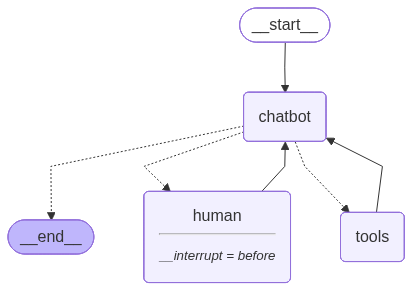

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "11"})


input = {"messages": [("user", "AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. HumanRequest를 호출해주세요.")]}


for event in graph.stream(input, config, stream_mode="values"):
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. HumanRequest를 호출해주세요.
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (fc_02562bee-33ad-4995-b2f4-eb9c60c74531)
 Call ID: fc_02562bee-33ad-4995-b2f4-eb9c60c74531
  Args:
    request: I need expert help building an AI agent.


In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. HumanRequest를 호출해주세요.', additional_kwargs={}, response_metadata={}, id='53e032f8-68c2-4f39-b9eb-bef2d8c8cf2c'), AIMessage(content='', additional_kwargs={'reasoning_content': 'User wants to build an AI agent, needs expert help. We should call HumanRequest with request.', 'tool_calls': [{'id': 'fc_02562bee-33ad-4995-b2f4-eb9c60c74531', 'function': {'arguments': '{"request":"I need expert help building an AI agent."}', 'name': 'HumanRequest'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 1477, 'total_tokens': 1530, 'completion_time': 0.051972053, 'prompt_time': 0.072577343, 'queue_time': 0.017396173, 'total_time': 0.124549396}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e11c8bbf69', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0865f4eb-3924-4b70-a941-2524296ea5cb-0', tool_calls=[{'name

In [ ]:
last_message = snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'HumanRequest',
  'args': {'request': 'I need expert help building an AI agent.'},
  'id': 'fc_02562bee-33ad-4995-b2f4-eb9c60c74531',
  'type': 'tool_call'}]

In [ ]:
from langchain_core.messages import ToolMessage


new_message = [
    ToolMessage(
        content="전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.",
        name=last_message.tool_calls[0]['name'],
        tool_call_id=last_message.tool_calls[0]['id'],
      )
    ]
new_message

[ToolMessage(content='전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.', name='HumanRequest', tool_call_id='fc_02562bee-33ad-4995-b2f4-eb9c60c74531')]

In [ ]:
graph.update_state(config=config, values={"messages":new_message}, as_node="human")

{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1f098ea9-b990-618d-8002-3471f46f6b69'}}

In [ ]:
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: HumanRequest

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.


In [ ]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. HumanRequest를 호출해주세요.
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (fc_02562bee-33ad-4995-b2f4-eb9c60c74531)
 Call ID: fc_02562bee-33ad-4995-b2f4-eb9c60c74531
  Args:
    request: I need expert help building an AI agent.
================================= Tool Message =================================
Name: HumanRequest

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
